<a href="https://colab.research.google.com/github/OoJackoO/MMAI894_Deep-Learning-Course-Project/blob/Nancy_notebook/BasicModelCNN_Final2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [48]:
# Import Tensor Flow and necessary libvraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from PIL import ImageFile

# data preprocessing and modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential

# others
import os, gc, time, pathlib
import tqdm, re, json
import imghdr
seed=24
image_size = (180, 180)


In [5]:

# environmental variables
TRAIN_DATA_PATH = '/content/drive/MyDrive/MMAI_Train/'
VALID_DATA_PATH = '/content/drive/MyDrive/MMAI_valid/'

CLASS_NAMES = sorted(os.listdir(TRAIN_DATA_PATH))
NUM_CLASSES = len(CLASS_NAMES)

In [6]:
# checking availability of GPUs/TPUs
ImageFile.LOAD_TRUNCATED_IMAGES = True
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **Load Data Using a Keras Utility**

Standard way of pulling data is from websit:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

Since I already download the file in the googledrive, Only Path is good enough 
#1 it iwll unizpped on "/content"
import pathlib
data = pathlib.Path('/content/folders_inside_zip') 
count = len(list(data.glob('*/*.jpg')))
count
#2 it if it already unziped in google drive
import pathlib
data = pathlib.Path('/content/gdrive/My Drive/TrainingPictures/') 
count = len(list(data.glob('*.jpg')))
count

In [7]:
# environmental variables
path_to_dir_train = "/content/drive/MyDrive/MMAI_Train/"
path_to_dir_valid = "/content/drive/MyDrive/MMAI_valid/"
     

# **STEP#2: Filter Out  Corrupted Images **
When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature t

In [8]:
def image_quality_check(image_dir):
  '''
  This functions checks whether file formats accepted by Tensorflow ( JPEG, PNG, GIF, BMP), or may be corrupted.
  '''
  from pathlib import Path
  import imghdr

  image_extensions = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']
  img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
  bad_images = []

  for filepath in Path(image_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            bad_images.append(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            bad_images.append(filepath)
  return bad_images
     

In [9]:
def image_quality_check2(image_dir):
  '''
  This function captures corrupted image files (jpg and png) that may missed by first QA function.
  '''
  import os, glob

  # validate directory
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  def is_valid_jpg(jpg_file):
    with open(jpg_file, 'rb') as f:
      f.seek(-2,2)
      buf = f.read()
      return buf == b'\xff\xd9'

  def is_valid_png(png_file):
    with open(png_file, 'rb') as f:
      f.seek(-2,2)
      but = f.read()
      return but == b'\x60\x82'

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.jpg', '.jpeg','.JPG', '.JPEG']:
        if not is_valid_jpg(fpath):
          print(fpath)
          bad_images.append(fpath)
      
      if file[index:] in ['.png', '.PNG']:
        if not is_valid_png(fpath):
          print(fpath)
          bad_images.append(fpath)

  return bad_images

In [10]:
def image_quality_check3(image_dir):
  '''
  This function focuses on identifying corrupted png images that may be missed by the QA1 and QA2.
  '''
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.png', '.PNG']:
        try:
          image = tf.io.read_file(fpath)
          image = tf.image.decode_png(image, channels=3)
        except:
          bad_images.append(fpath)
          print('defective image file: ', fpath)
  return bad_images

In [11]:
# check image quality
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train = image_quality_check(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test = image_quality_check(VALID_DATA_PATH)
     

# check image quality 2
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train2 = image_quality_check2(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test2 = image_quality_check2(VALID_DATA_PATH)
     

# check image quality 3
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train3 = image_quality_check3(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test3 = image_quality_check3(VALID_DATA_PATH)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.34 µs
-------------------- check training set image quality. --------------------
-------------------- check test and validation set image quality. --------------------
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
-------------------- check training set image quality. --------------------


powdery_mildew         : 100%|████████████████████████████████████████| 1004/1004 [00:00<00:00, 1232.07file/s]


-------------------- check test and validation set image quality. --------------------


powdery_mildew         : 100%|██████████████████████████████████████████| 252/252 [00:00<00:00, 1304.39file/s]


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
-------------------- check training set image quality. --------------------


powdery_mildew         : 100%|██████████████████████████████████████| 1004/1004 [00:00<00:00, 428216.52file/s]


-------------------- check test and validation set image quality. --------------------


powdery_mildew         : 100%|████████████████████████████████████████| 252/252 [00:00<00:00, 503316.48file/s]


In [12]:

move_bad_images = True
bad_images = set(bad_images_train + bad_images_val_test + bad_images_train2 + bad_images_val_test2 + bad_images_train3 + bad_images_val_test3)
bad_images

if move_bad_images:
  for link in bad_images:
    if os.path.exists(link):
      os.remove(str(link))

print('Move {} images with bad quality.'.format(len(bad_images)))
     

# check number of images remained
train_len, test_len = 0, 0
for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))
print(train_len);print(test_len)


Move 0 images with bad quality.
25836
6677


# **STEP#3: **
# **Generate a Dataset **

In [26]:
## Define some parameters for the loader
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH =224
LABEL_MODE = 'categorical'
COLOR_MODE = 'rgb'

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path_to_dir_train,
  validation_split=0.5,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25835 files belonging to 11 classes.
Using 12918 files for training.


In [30]:

# validation and test sets - expect 6684 (6,677) images
val_test_ds = keras.utils.image_dataset_from_directory(
        VALID_DATA_PATH,
        batch_size =batch_size , 
        image_size = (img_height, img_width), 
        label_mode='categorical' ,
        color_mode='rgb' ,
        shuffle=True,
        seed = 123,
        validation_split = 0.5, 
        subset = 'both',
        )

valid_ds = val_test_ds[0]
test_ds = val_test_ds[1]

Found 6677 files belonging to 11 classes.
Using 3339 files for training.
Using 3338 files for validation.


In [12]:
# audit - make sure validation and test sets are approximately follow same distributi
assert ((train_ds.class_names == valid_ds.class_names) and (train_ds.class_names == test_ds.class_names)), 'Labels in training, validation, and test do not match'

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# **Visualize the Data**
Here are the first 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat".

(-0.5, 223.5, 223.5, -0.5)

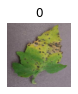

In [38]:
ax = plt.subplot(3, 3, i + 1)
plt.imshow(images[i].numpy().astype("uint8"))
plt.title(int(labels[i].numpy()[0]))
plt.axis("off")

Data Preprocessing 
image preprocessing layers: standardizing the inputs of an image model
when you export your model using model save, the preprocessing layrers will be saved a

## Using Image Data Augmentation 
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [42]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

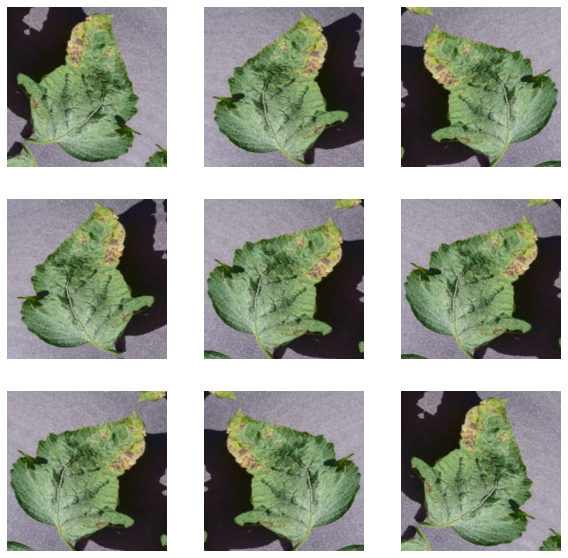

In [43]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Configure the dataset for performance

In [46]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Build a Model 

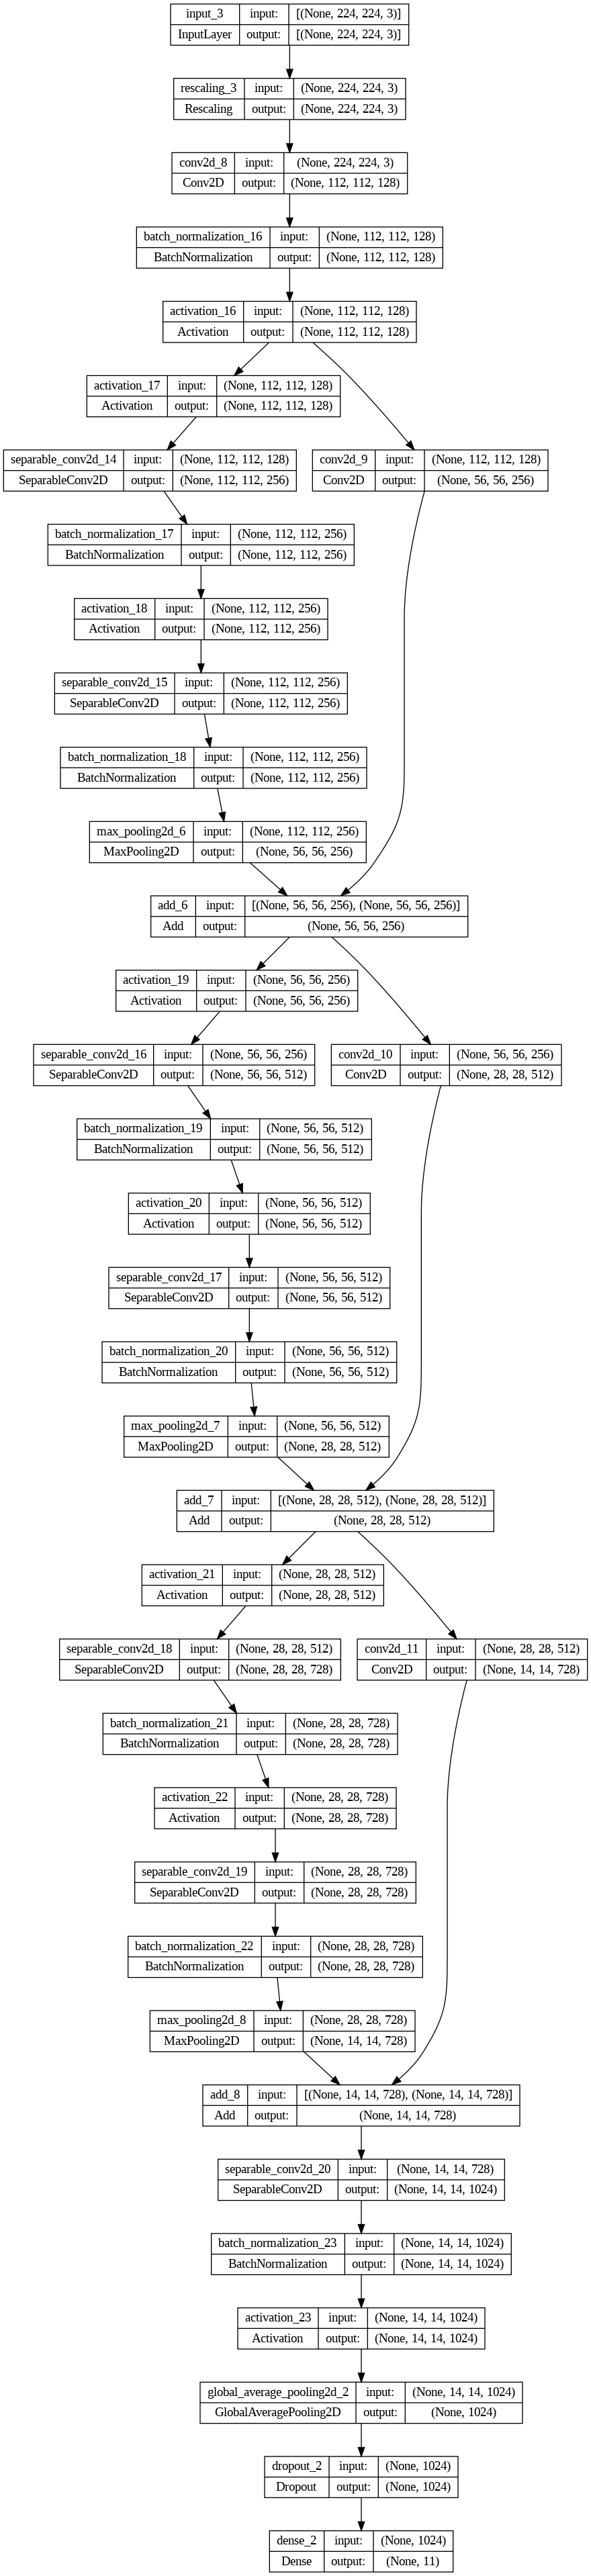

In [54]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    #outputs = layers.Dense(units, activation=activation)(x)
    outputs = layers.Dense(11, activation="softmax")(x)  # change the number of output units
    return keras.Model(inputs, outputs)

#model = make_model(input_shape=image_size + (3,), num_classes=2)
model = make_model(input_shape=(224, 224, 3), num_classes=2)

keras.utils.plot_model(model, show_shapes=True)

In [55]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=valid_ds,
)

Epoch 1/25
808/808 [==============================] - 920s 1s/step - loss: 0.1784 - accuracy: 0.5964 - val_loss: 0.3027 - val_accuracy: 0.4654
Epoch 2/25
808/808 [==============================] - 68s 84ms/step - loss: 0.1106 - accuracy: 0.7683 - val_loss: 0.3322 - val_accuracy: 0.4708
Epoch 3/25
808/808 [==============================] - 68s 84ms/step - loss: 0.0817 - accuracy: 0.8339 - val_loss: 0.1072 - val_accuracy: 0.7757
Epoch 4/25
808/808 [==============================] - 68s 84ms/step - loss: 0.0668 - accuracy: 0.8660 - val_loss: 0.1324 - val_accuracy: 0.7502
Epoch 5/25
808/808 [==============================] - 68s 84ms/step - loss: 0.0599 - accuracy: 0.8801 - val_loss: 0.2291 - val_accuracy: 0.5915
Epoch 6/25
808/808 [==============================] - 68s 84ms/step - loss: 0.0519 - accuracy: 0.8981 - val_loss: 0.0970 - val_accuracy: 0.8302
Epoch 7/25
808/808 [==============================] - 68s 83ms/step - loss: 0.0465 - accuracy: 0.9089 - val_loss: 0.0956 - val_accuracy: 

In [56]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 112, 112, 12  3584        ['rescaling_3[0][0]']            
                                8)                                                                
                                                                                            

In [57]:
import numpy as np

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

xy = np.concatenate([x, y], axis=0)

In [59]:
def plot_training(hist):
  '''
  This function plots training history. (ie training loss vs validation loss)
  '''
  tr_acc = hist.history['accuracy']
  tr_loss = hist.history['loss']
  val_acc = hist.history['val_accuracy']
  val_loss = hist.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]

  plt.figure(figsize= (8, 8))
  plt.style.use('fivethirtyeight')
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout
  plt.show()
     

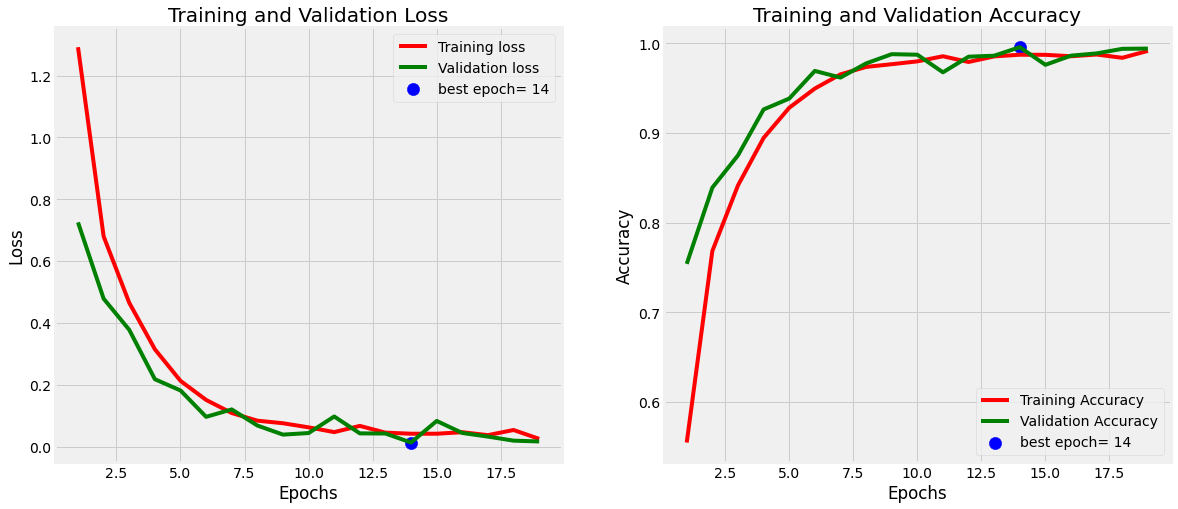

In [ ]:

plot_training(history)